In [1]:
%matplotlib inline
from IPython.display import HTML
import os
import os.path
import pathlib
import sys
import math
import numpy as np
import pandas
from matplotlib import pyplot

_libdir = str( pathlib.Path( os.path.abspath('') ).parent / "lib" )
if _libdir not in sys.path:
    sys.path.insert( 0, _libdir )

from mosthosts_desi import MostHostsDesi

## Finding all DESI observations of MostHosts objects

The MostHostsDesi class will match all of the RA/Dec from Mosthosts to the daily tables of observations from DESI.  It builds a (somewhat complicated) Pandas datastructure with all of the matches, and then writes that data structure to a csv file.  Look at `mosthosts_desy.py` and the docstring on `MostHostsDesi` for documentation on how it works.

In [2]:
# To actually use this, you'll need to pass a database user and password.
# See the docstring on MostHostsDesi.__init__ for more information.
# Don't save any passwords to a github archive!
# Release can be one of : daily , everest , fuji , guadalupe , fujilupe
#  (fujilupe is the union of fuji and guadalupe — and currently is broken!)
# By default, this reads mosthosts_desi_{release}.csv from the local
#   directory.  Set force_regen=True to make it rebuild that file.
# subset = "iron"
mhd_iron = MostHostsDesi( release="iron", force_regen=False, dbuserpwfile="/global/homes/r/raknop/secrets/decatdb_desi_desi" )
sys.stderr.write( "Read Iron.\n" )
mhd_daily = MostHostsDesi( release="daily", force_regen=False, dbuserpwfile="/global/homes/r/raknop/secrets/decatdb_desi_desi" )
sys.stderr.write( "Read Daily.\n" )

[2024-02-12 11:29:41,080 - INFO] - Loading mosthosts table...
[2024-02-12 11:29:47,939 - INFO] - ...mosthosts table loaded.
[2024-02-12 11:29:47,960 - INFO] - Read dataframes from pkl files
Read Iron.
[2024-02-12 11:29:47,969 - INFO] - Loading mosthosts table...
[2024-02-12 11:29:55,278 - INFO] - ...mosthosts table loaded.
[2024-02-12 11:29:55,294 - INFO] - Read dataframes from pkl files
Read Daily.


12

In [3]:
mhd = mhd_daily;

In [4]:
# Print out some statistics
print( f'...as of when the csv and pkl files were last regenerated:' )
print( f'{len(mhd.df)} entries in the MostHosts database' )
print( f'{len(mhd.df.groupby("sn_name_sp"))} different SNe in MostHosts database' )
print( f'{mhd.df["z"].notnull().sum()} hosts have at least one DESI zwarn=0 redshift' )
print( f'{len( mhd.df[ mhd.df["z"].notnull() ].groupby( "sn_name_sp" ) )} SNe have at least one host observed by DESI' )
# I put this here as a self-consistency check between my two dataframes
print( f'The same number again: {len( mhd.haszdf[ mhd.haszdf["zwarn"]==0 ].reset_index().groupby( "sn_name_sp" ) )}' )



...as of when the csv and pkl files were last regenerated:
59975 entries in the MostHosts database
38544 different SNe in MostHosts database
21594 hosts have at least one DESI zwarn=0 redshift
19956 SNe have at least one host observed by DESI
The same number again: 19956


In [5]:
# If you want to figure out which supernovae have multiple hosts, you can poke at the mhd.df dataframe similar to the following

origtablehostcount = mhd.df.reset_index().groupby( "sn_name_sp" ).count()["hostnum"]
for i in range( 1, 8 ):
    print( f'{(origtablehostcount == i).sum()} candidates in the mosthosts table have {i} hosts' )
# print( f'The candidates with 3 observed hosts are: {origtablehostcount[origtablehostcount == 5].index.values}' )

print( '' )

obshostcount = mhd.df[ mhd.df['z'].notnull() ].reset_index().groupby( "sn_name_sp" ).count()["hostnum"]
for i in range( 1, 8 ):
    print( f'{(obshostcount == i).sum()} candidates have {i} hosts observed by DESI with zwarn=0' )

22597 candidates in the mosthosts table have 1 hosts
10903 candidates in the mosthosts table have 2 hosts
4672 candidates in the mosthosts table have 3 hosts
340 candidates in the mosthosts table have 4 hosts
8 candidates in the mosthosts table have 5 hosts
18 candidates in the mosthosts table have 6 hosts
0 candidates in the mosthosts table have 7 hosts

18374 candidates have 1 hosts observed by DESI with zwarn=0
1528 candidates have 2 hosts observed by DESI with zwarn=0
52 candidates have 3 hosts observed by DESI with zwarn=0
2 candidates have 4 hosts observed by DESI with zwarn=0
0 candidates have 5 hosts observed by DESI with zwarn=0
0 candidates have 6 hosts observed by DESI with zwarn=0
0 candidates have 7 hosts observed by DESI with zwarn=0


In [6]:
# Set to True to show the ones have 3 hosts observed by DESI
if False:
    mrows = pandas.options.display.max_rows
    pandas.set_option( "display.max_rows", 9999 )
    display( mhd.haszdf.loc[ obshostcount[ obshostcount==3 ].index.values ] )
    pandas.set_option( "display.max_rows", mrows )

In [7]:
nzwarn0 = ( mhd.haszdf.zwarn == 0 ).sum()
succfrac = nzwarn0 / len( mhd.haszdf )
print( f"{nzwarn0} of {len(mhd.haszdf)} coadded DESI observations have zwarn=0 ({succfrac:.3f})" )

dex = np.array( [ i[0:3]=='ZTF' for i in mhd.haszdf.index.get_level_values( 0 ) ] )
subdf = mhd.haszdf[ dex ]
nzwarn0 = ( subdf.zwarn == 0 ).sum()
succfrac = nzwarn0 / len( subdf )
print( f"{nzwarn0} of {len(subdf)} coadded DESI observation of 'ZTF*' objects have zwarn=0 ({succfrac:.3f})" )

dex = np.array( [ i[0:3]=='PTF' or i[0:4]=='iPTF' for i in mhd.haszdf.index.get_level_values( 0 ) ] )
subdf = mhd.haszdf[ dex ]
nzwarn0 = ( subdf.zwarn == 0 ).sum()
succfrac = nzwarn0 / len( subdf )
print( f"{nzwarn0} of {len(subdf)} coadded DESI observations of '[i]PTF*' objects have zwarn=0 ({succfrac:.3f})" )


12864 of 13341 coadded DESI observations have zwarn=0 (0.964)
4571 of 4747 coadded DESI observation of 'ZTF*' objects have zwarn=0 (0.963)
855 of 891 coadded DESI observations of '[i]PTF*' objects have zwarn=0 (0.960)


***

## Pulling out information about a specific host from MostHosts

Suppose you want to find out the summary information (i.e. the `df` entry) and all the observations (the `haszdf` entry) for supernova ZTF18acueixn, host 2:

In [8]:
# Once again, I wish I could figure out how to do this cleanly in Pandas
# without resetting the index, and then setting the index back hardcodedly
# to what it was in the first place.

sntoshow = 'PTF10cwp'
dextoshow = 1

_tmp = mhd.df.reset_index()
subdf = _tmp.loc[ ( _tmp['sn_name_sp'] == sntoshow ) & ( _tmp['hostnum'] == dextoshow ) ].set_index( ['sn_name_sp', 'hostnum'] )
display( HTML( f'<h3>rows of mhd.df for spname={sntoshow} host {dextoshow}</h3>' ) )
display( subdf )

_tmp = mhd.haszdf.reset_index()
display( HTML( f'<br><hr><br><h3>rows of mhd.haszdf for spname={sntoshow} host {dextoshow}</h3>' ) )
subdf = _tmp.loc[ ( _tmp['sn_name_sp'] == sntoshow ) & ( _tmp['hostnum'] == dextoshow ) ].set_index( ['sn_name_sp', 'hostnum', 
                                                                                            'targetid', 'petal', 'night' ] )
display( subdf )

#_tmp = mhd.haszdf.reset_index().groupby( ['snname','index'] )['z'].count()
#_tmp[ _tmp > 2 ]

,,ra,dec,sn_ra,sn_dec,sn_z,z,zerr,zdisp
sn_name_sp,hostnum,,,,,,,,
PTF10cwp,1,179.66113,-0.560803,179.661208,-0.560854,0.095,0.094964,0.000002,0.000001


tileid         ra  \
sn_name_sp hostnum targetid          petal night                         
PTF10cwp   1       39627775660789402 0     20210506      36  179.66113   
                                           20210513     445  179.66113   
                                     9     20220228    7706  179.66113   

                                                          dec       sn_ra  \
sn_name_sp hostnum targetid          petal night                            
PTF10cwp   1       39627775660789402 0     20210506 -0.560803  179.661208   
                                           20210513 -0.560803  179.661208   
                                     9     20220228 -0.560803  179.661208   

                                                       sn_dec   sn_z  \
sn_name_sp hostnum targetid          petal night                       
PTF10cwp   1       39627775660789402 0     20210506 -0.560854  0.095   
                                           20210513 -0.560854  0.095   
                                     9     20220228 -0.560854  0.095   

                                                            z          zerr  \
sn_name_sp hostnum targetid          petal night                              
PTF10cwp   1       39627775660789402 0     20210506  0.932752  2.232146e-46   
                                           20210513  0.094963  2.472312e-06   
                                     9     20220228  0.094964  2.687948e-06   

                                                     zwarn          chi2  \
sn_name_sp hostnum targetid          petal night                           
PTF10cwp   1       39627775660789402 0     20210506    518  9.000000e+99   
                                           20210513      0  8.624723e+03   
                                     9     20220228      0  7.951915e+03   

                                                       deltachi2 spectype  \
sn_name_sp hostnum targetid          petal night                            
PTF10cwp   1       39627775660789402 0     20210506     0.000000   GALAXY   
                                           20210513  5366.930827   GALAXY   
                                     9     20220228  4178.166438   GALAXY   

                                                    subtype  
sn_name_sp hostnum targetid          petal night             
PTF10cwp   1       39627775660789402 0     20210506          
                                           20210513          
                                     9     20220228

***

## Finding DESI targets from the main survey that are mosthosts

Call the `find_main_targets` method of your MostHostsDesi object to load up the property `maintargets` with a data frame that matches targets from the DESI main survey to mosthsots.  By default, it searches for targets within 1" of the position of the MostHosts host.

In [9]:
# Match mosthosts to main desi targets
# Set force_regen=True to actually read the database; otherwise
# it will try to read a pickle file in the current directory
mhd.find_main_targets( force_regen=False )

print( f"{len(mhd.maintargets.groupby( ['sn_name_sp', 'hostnum'] ).first())} "
       f"of {len(mhd.df)} mosthosts show up in DESI main targets" )

subdf = mhd.maintargets[ mhd.maintargets['bgs_target'] > 0 ]
print( f"{len(subdf.groupby( ['sn_name_sp', 'hostnum'] ).first())} "
       f"of {len(mhd.df)} mosthosts have a bgs_target > 0" )


[2024-02-01 11:44:22,669 - INFO] - MainTargets info read from mosthosts_desi_maintargets.pkl


36255 of 59975 mosthosts show up in DESI main targets
34429 of 59975 mosthosts have a bgs_target > 0


In [10]:
# Suppose we want to find if there are mosthosts associated with a given targetid:

# targid = 39633472859408454   # THis is one that, at least as of this writing, had no observations yet
targid = 39628438620867604     # This one has multiple targetIDs that match the same mosthosts entry, and multiple observations

mytargmh = mhd.maintargets.xs( targid, level='targetid' )
# (This will throw a KeyError exception if targid isn't found in mhd.maintargets.)

display( HTML(f"<h3>Mosthosts for target {targid}:") )
display( mytargmh )

# If we want to see if they have any redshifts:

_dexes = list( set( mytargmh.reset_index().set_index( ['sn_name_sp', 'hostnum'] ).index ) )

display( HTML(f"<h3>Summary redshift info (if any) for mosthosts that overlap {targid}:") )
display( mhd.df.loc[ _dexes, [ 'sn_z','z','zerr','zdisp' ] ] )

#...there must be a better way to do pandas subsetting than all
# this reset_index() followed by a set_index() to what the index
# was in the first place.

display( HTML(f"<h3>Full redshift info (if any) for target {targid}:") )
_tmpdf = mhd.haszdf.reset_index().set_index( ['sn_name_sp','hostnum'] )
_dexes = [ d for d in _dexes if d in mhd.haszdf.index ]
display( _tmpdf.loc[ _dexes ].reset_index().set_index( ['sn_name_sp', 'hostnum', 'targetid', 'tileid', 'petal', 'night'] ) )


,,,,sn_name_tns,sn_name_iau,sn_name_ptf,desi_target,bgs_target,mws_target,scnd_target
sn_name_sp,hostnum,survey,whenobs,,,,,,,
PSNJ1300323,3,main,bright,None,None,None,5764607523034234880,131074,0,79164837199872


,,sn_z,z,zerr,zdisp
sn_name_sp,hostnum,,,,
PSNJ1300323,3,0.024067,0.025733,0.000012,0.000009


ra  \
sn_name_sp  hostnum targetid            tileid petal night                  
PSNJ1300323 3       39628438620867604   121    8     20210416  195.118313   
                    2305843020093723866 131    9     20210406  195.118313   

                                                                     dec  \
sn_name_sp  hostnum targetid            tileid petal night                 
PSNJ1300323 3       39628438620867604   121    8     20210416  27.972406   
                    2305843020093723866 131    9     20210406  27.972406   

                                                                    sn_ra  \
sn_name_sp  hostnum targetid            tileid petal night                  
PSNJ1300323 3       39628438620867604   121    8     20210416  195.134651   
                    2305843020093723866 131    9     20210406  195.134651   

                                                                  sn_dec  \
sn_name_sp  hostnum targetid            tileid petal night                 
PSNJ1300323 3       39628438620867604   121    8     20210416  27.978087   
                    2305843020093723866 131    9     20210406  27.978087   

                                                                   sn_z  \
sn_name_sp  hostnum targetid            tileid petal night                
PSNJ1300323 3       39628438620867604   121    8     20210416  0.024067   
                    2305843020093723866 131    9     20210406  0.024067   

                                                                      z  \
sn_name_sp  hostnum targetid            tileid petal night                
PSNJ1300323 3       39628438620867604   121    8     20210416  0.025729   
                    2305843020093723866 131    9     20210406  0.025739   

                                                                   zerr  \
sn_name_sp  hostnum targetid            tileid petal night                
PSNJ1300323 3       39628438620867604   121    8     20210416  0.000015   
                    2305843020093723866 131    9     20210406  0.000022   

                                                               zwarn  \
sn_name_sp  hostnum targetid            tileid petal night             
PSNJ1300323 3       39628438620867604   121    8     20210416      0   
                    2305843020093723866 131    9     20210406      0   

                                                                       chi2  \
sn_name_sp  hostnum targetid            tileid petal night                    
PSNJ1300323 3       39628438620867604   121    8     20210416  12242.738077   
                    2305843020093723866 131    9     20210406   8712.552436   

                                                                 deltachi2  \
sn_name_sp  hostnum targetid            tileid petal night                   
PSNJ1300323 3       39628438620867604   121    8     20210416  6015.712301   
                    2305843020093723866 131    9     20210406  2706.258356   

                                                              spectype subtype  
sn_name_sp  hostnum targetid            tileid petal night                      
PSNJ1300323 3       39628438620867604   121    8     20210416   GALAXY          
                    2305843020093723866 131    9     20210406   GALAXY

***

## Some summary plots

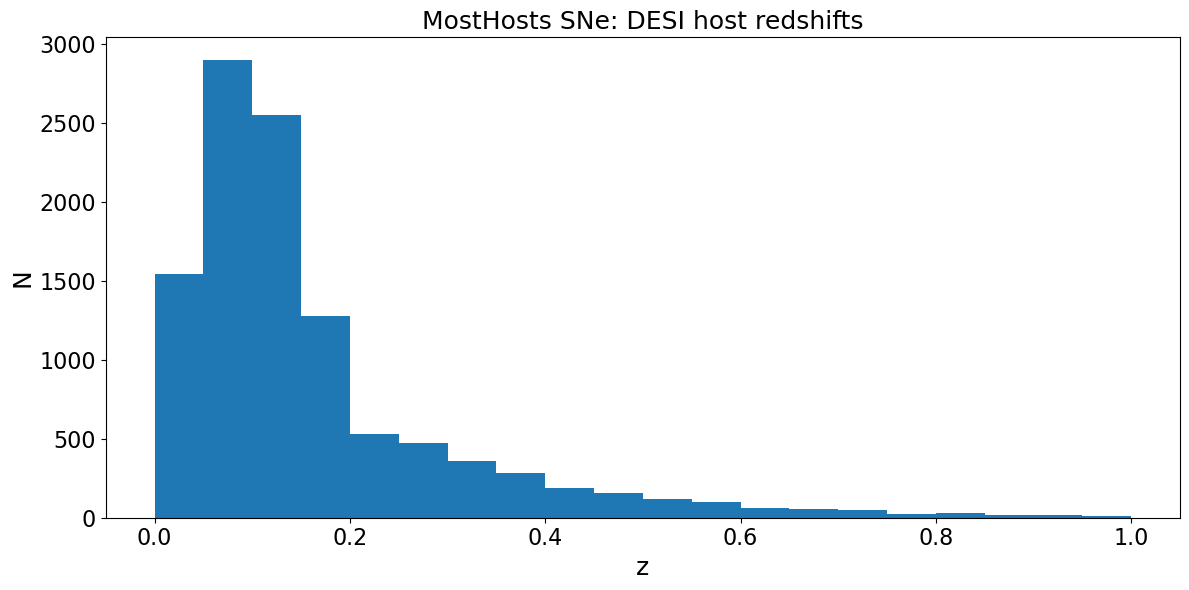

In [13]:
# Make a histogram of independent supernova z and AGN.  The host z might not be the right one, as
#   the plot just naively grabs the first host listed for each SN.

subframe = mhd.df[ mhd.df['z'].notnull() ].groupby( 'sn_name_sp' ).agg('first')

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
hist = ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe: DESI host redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()
fig.savefig( f'mosthostsz_{mhd.release}.svg' )


In [20]:
histdf = pandas.DataFrame( { 'z_bin': hist[1][:-1], 'N': np.array( hist[0], dtype=int ) } )
histdf.to_csv( 'Mosthosts_Desi_z_Histogram.csv' )

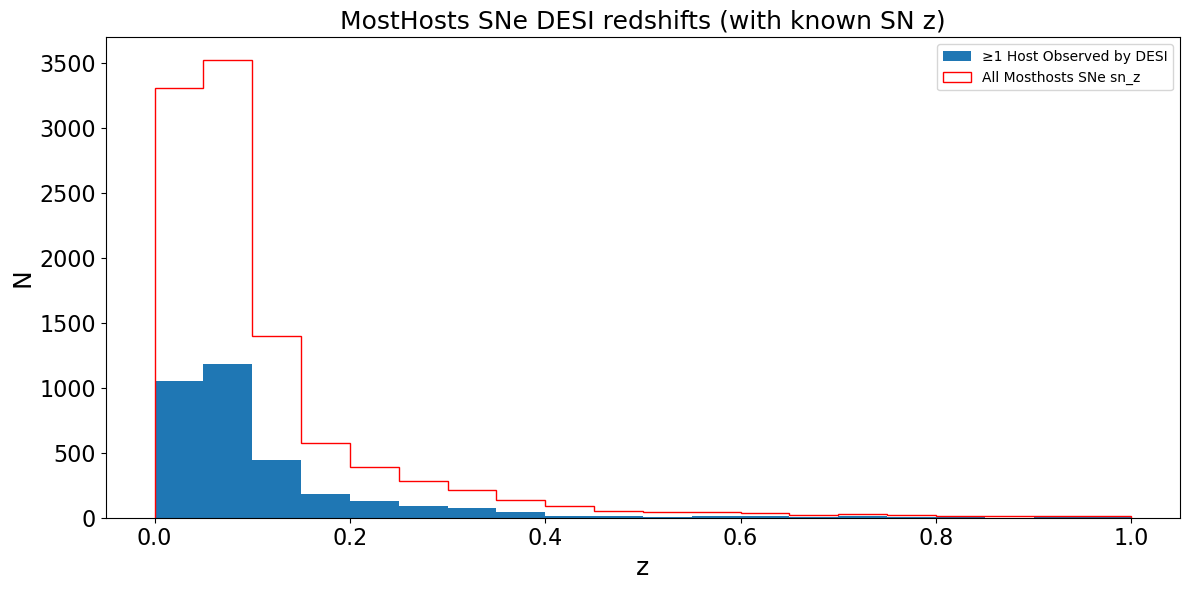

In [20]:
# Make a histogram of *independent* supernova zs.  I'm just going to take the first measurement
#  for each supernova... which may well not be the right one!

subframe = mhd.haszdf.groupby( 'sn_name_sp' ).agg('first')
allmh = mhd.mosthosts.groupby( 'sn_name_sp' ).agg('first')

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['sn_z'], range=(0,1), bins=20, label="≥1 Host Observed by DESI" )
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI redshifts (with known SN z)', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )

ax.hist( allmh['sn_z'], range=(0, 1), bins=20, histtype='step', color='red', label="All Mosthosts SNe sn_z" )

ax.legend()

fig.show()
fig.savefig( f'mosthosts_justsnez_{mhd.release}.svg' )


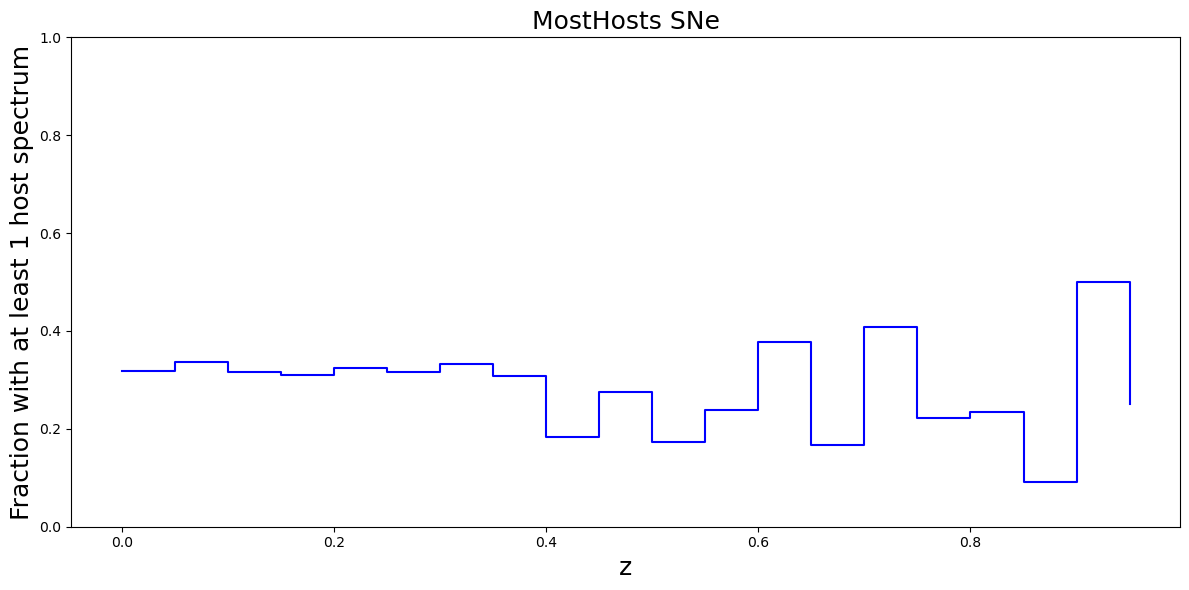

In [21]:
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1)
obshist, obsbins = np.histogram( subframe['sn_z'], range=(0,1), bins=20 )
allhist, allbins = np.histogram( allmh['sn_z'], range=(0,1), bins=20 )
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('Fraction with at least 1 host spectrum', fontsize=18)
ax.set_title( 'MostHosts SNe', fontsize=18 )
ax.set_ylim( 0, 1 )
ax.step( allbins[:-1], obshist/allhist, where='post', color='blue' )
fig.show()


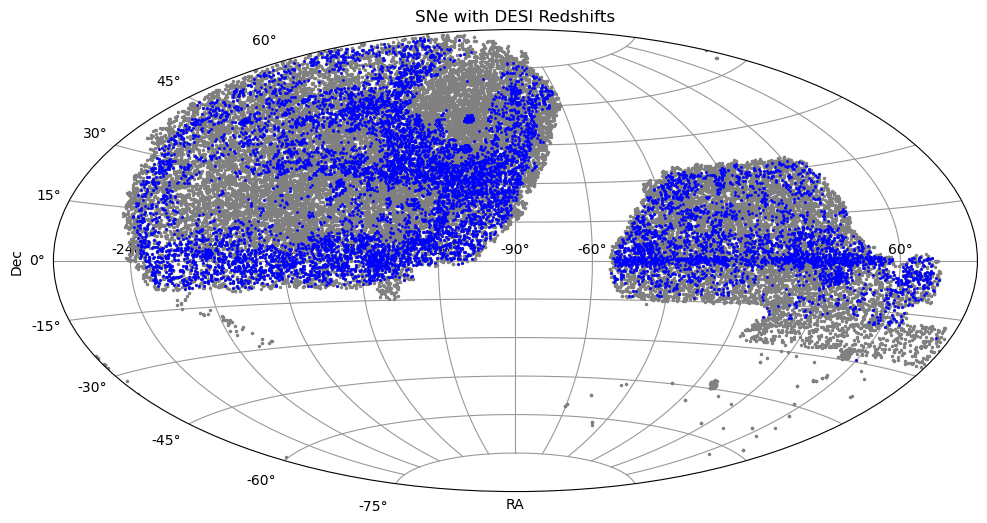

In [22]:
# Plot them on the sky

whichmhd = mhd_iron

allmhsubframe = whichmhd.df.groupby( 'sn_name_sp' ).agg( 'first' )
subframe = whichmhd.df[ mhd.df['z'].notnull() ].groupby( 'sn_name_sp' ).agg('first')

fig = pyplot.figure( figsize=(12,6) )
ax = fig.add_subplot(1, 1, 1, projection='aitoff' )

raoff = 90

# I want to plot the aitoff projection not having 0 at the center
# I don't know if there's a simple argument to give to the axes for
# this, so I'll manually offset my RAs, and then manually edit the
# tick labels, to offset by raoff degrees.
def plot_aitoff_ra_dec( ras, decs, marker='o', markersize=1, color='blue', raoff=90 ):
    decs *= math.pi  / 180.
    ras = ( ras + raoff ) * math.pi/180.
    ras[ ras < -math.pi ] = ras[ ras < -math.pi ] + 2*math.pi
    ras[ ras >= math.pi ] = ras[ ras >= math.pi ] - 2*math.pi
    ax.set_longitude_grid( 30 )
    ax.set_latitude_grid( 15 )
    ax.grid( which='major', color='#999999' )
    ax.plot( ras, decs, linestyle='None', marker=marker, markersize=markersize, color=color )

plot_aitoff_ra_dec( allmhsubframe['ra'].values, allmhsubframe['dec'].values, markersize=1.5, color='grey', raoff=raoff )
plot_aitoff_ra_dec( subframe['ra'].values, subframe['dec'].values, markersize=1., color='blue', raoff=raoff )
    
fig.canvas.draw()

labels = [ f'{float(lab.get_text()[:-1])-raoff:.0f}°' for lab in ax.get_xticklabels() ]
ax.set_xticklabels( labels )
# Remove the 75° label so it doesn't overlap the title.
# THere's probably a more elegant way to do this.
labels = [ lab for lab in ax.get_yticklabels()[:-1] ] + ['']
ax.set_yticklabels( labels )
ax.set_xlabel( "RA" )
ax.set_ylabel( "Dec" )
ax.set_title( "SNe with DESI Redshifts" )
fig.show()
fig.savefig( f'mosthostdesiz_skydist_{whichmhd.release}.svg' )

KeyError: 'deltachi2'

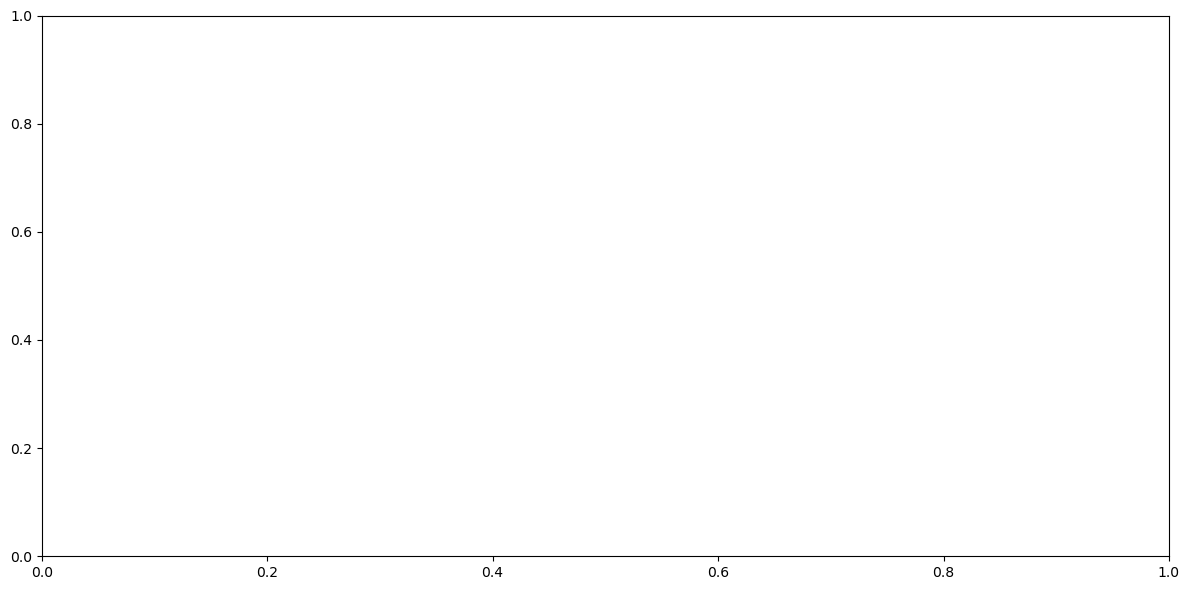

In [23]:
subframe = mhd.df.groupby( 'sn_name_sp' ).agg('first')

fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['deltachi2'].values, range=(0,500), bins=40)
ax.set_xlabel('deltachi2', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI Δχ² of first observation in list', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()


## Stuff below is just futzing around with the tables to subset by name, etc.

In [24]:
subframe = justsne.groupby( 'snname' ).agg('first')
dexes = subframe.index.values
ztfobjs = subframe[ [ it[0:3]=='ZTF' for it in dexes ] ]
# I know I could have done a pandas count something something,
# but I might want this subframe later.
print( f"There are {len(ztfobjs)} SNe with DESI-observed hosts whose names start with \"ZTF\"" )

NameError: name 'justsne' is not defined

In [25]:
tmp = mhd.df.reset_index()
dexes = tmp.index.values
tmp[ [ tmp.snname[i][0:3]=='ZTF' for i in dexes ] ].groupby( 'snname' ).agg('first')

AttributeError: 'DataFrame' object has no attribute 'snname'

In [15]:
# Save these ZTF supernovae to a file for my own sinister purposes
ztfobjs[ ['z', 'ra', 'dec' ] ]
with open( "cheesyfujiztflist.txt", "w" ) as ofp:
    for i in range(len(ztfobjs)):
        ofp.write( f"{ztfobjs.reset_index()['snname'][i]} {ztfobjs.reset_index()['ra'][i]} {ztfobjs.reset_index()['dec'][i]}\n" )
        

In [16]:
ztfobjs['program'].unique()

array(['SNe_Ia', 'SNe_Ia/RCF/ZTFmarshal', 'ZTFmarshal', 'SNe_Ia/RCF',
       'SNe_Ia/ZTFmarshal', 'RCF', 'RCF/ZTFmarshal', 'IIps/ZTFmarshal',
       'RCF/IIps/ZTFmarshal', 'SNe_Ia/RCF/IIps/ZTFmarshal',
       'SNe_Ia/IIps/ZTFmarshal', 'SNe_Ia/RCF/Anna', 'one_shot_dL',
       'Anna/ZTFmarshal', 'RCF/RCF/RCF/ZTFmarshal/ZTFmarshal'],
      dtype=object)

In [17]:
# ztfobjs['program'].values is an object, not a string, so this is convolted
ztfsne = ztfobjs[ np.char.find( np.array( ztfobjs['program'].values, dtype=str ), 'SNe_Ia' ) >= 0 ]
print( f'There are {len(ztfsne)} SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"' )

There are 1012 SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"


In [18]:
justptf = justsne[ justsne['ptfiptf_name'] != 'None' ]
print( f'There are {len(justptf)} SNe with a non-"None" ptfiptf_name' )

There are 888 SNe with a non-"None" ptfiptf_name


(-0.01, 0.01)

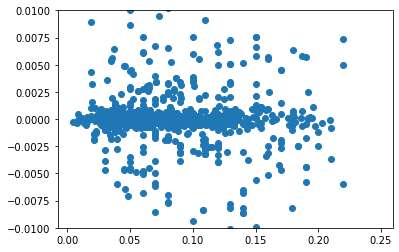

In [19]:
pyplot.plot( justptf['sn_z'], justptf['z']-justptf['sn_z'], linestyle='', marker='o' )
pyplot.ylim( -0.01, 0.01 )

In [20]:

pandas.options.display.max_rows = 500
justptf[ ['ptfiptf_name', 'ra', 'dec', 'z'] ]

ptfiptf_name  \
snname index targetid            tileid petal night                   
09ac   1     39633204071631854   20620  9     20220421      PTF09ac   
09aj   1     39627943986595403   23097  8     20220406      PTF09aj   
09alu  1     39633304558764813   174    4     20210405     PTF09alu   
                                 182    4     20210506     PTF09alu   
09amm  1     39633039919156981   25475  1     20220512     PTF09amm   
...                                                             ...   
15wd   1     39633321822522160   81058  2     20210324     iPTF15wd   
15wk   1     39628243766084410   24481  9     20211021     iPTF15wk   
15xc   1     39632945849304349   21175  0     20210516     iPTF15xc   
15zr   1     39633311340954958   81066  0     20210326     iPTF15zr   
             2305843015475793700 41610  3     20220316     iPTF15zr   

                                                                ra        dec  \
snname index targetid            tileid petal night                             
09ac   1     39633204071631854   20620  9     20220421  186.149690  47.237527   
09aj   1     39627943986595403   23097  8     20220406  146.376831   6.539819   
09alu  1     39633304558764813   174    4     20210405  214.572816  53.788987   
                                 182    4     20210506  214.572816  53.788987   
09amm  1     39633039919156981   25475  1     20220512  230.872538  37.878850   
...                                                            ...        ...   
15wd   1     39633321822522160   81058  2     20210324  174.725250  55.057643   
15wk   1     39628243766084410   24481  9     20211021  128.766206  19.185778   
15xc   1     39632945849304349   21175  0     20210516  186.079167  33.183806   
15zr   1     39633311340954958   81066  0     20210326  179.745833  54.239028   
             2305843015475793700 41610  3     20220316  179.745833  54.239028   

                                                               z  
snname index targetid            tileid petal night               
09ac   1     39633204071631854   20620  9     20220421  0.163469  
09aj   1     39627943986595403   23097  8     20220406  0.086857  
09alu  1     39633304558764813   174    4     20210405  0.074413  
                                 182    4     20210506  0.074455  
09amm  1     39633039919156981   25475  1     20220512  0.066120  
...                                                          ...  
15wd   1     39633321822522160   81058  2     20210324  0.057354  
15wk   1     39628243766084410   24481  9     20211021  0.208930  
15xc   1     39632945849304349   21175  0     20210516  0.021921  
15zr   1     39633311340954958   81066  0     20210326  0.012237  
             2305843015475793700 41610  3     20220316  0.012212  

[888 rows x 4 columns]

In [21]:
# Get a count of how many times each host has zwarn=0 observations
numobs = mhd.haszdf.groupby(level=[0,1]).aggregate('count').rename( {'ra': 'numobs'}, axis=1 )['numobs']

In [22]:
numobs[numobs>3]

snname                      index
09iag                       1        4
10ctd                       1        4
10wxp                       1        4
12dnn                       1        6
13adc                       1        7
2006lj                      1        4
AGN_1005                    1        4
AGN_1025                    1        4
AGN_1068                    1        5
AGN_1070                    1        5
AGN_1133                    1        4
AGN_1155                    1        6
AGN_1163                    1        4
AGN_1235                    1        4
AGN_1242                    1        4
AGN_1280                    1        4
AGN_1317                    1        4
AGN_1351                    1        6
AGN_1433                    1        4
AGN_144                     1        4
AGN_1464                    1        4
AGN_1486                    1        4
AGN_1520                    1        6
AGN_1548                    1        4
AGN_1612                    1 

In [23]:
mhd.haszdf.xs( 'ZTF18aavniyw', level=0 )

ra        dec  pmra  \
index targetid            tileid petal night                                   
1     39633274766623836   20593  6     20220317  172.876147  51.628972   0.0   
                          22162  1     20220218  172.876147  51.628972   0.0   
                          81064  4     20210327  172.876147  51.628972   0.0   
      2305843015459014979 81088  6     20210404  172.876147  51.628972   0.0   

                                                 pmdec  ref_epoch  override  \
index targetid            tileid petal night                                  
1     39633274766623836   20593  6     20220317    0.0        0.0     False   
                          22162  1     20220218    0.0        0.0     False   
                          81064  4     20210327    0.0        0.0     False   
      2305843015459014979 81088  6     20210404    0.0        0.0     False   

                                                hemisphere       sn_ra  \
index targetid            tileid petal night                             
1     39633274766623836   20593  6     20220317      north  172.875062   
                          22162  1     20220218      north  172.875062   
                          81064  4     20210327      north  172.875062   
      2305843015459014979 81088  6     20210404      north  172.875062   

                                                    sn_dec   sn_z  ...  \
index targetid            tileid petal night                       ...   
1     39633274766623836   20593  6     20220317  51.629381  0.055  ...   
                          22162  1     20220218  51.629381  0.055  ...   
                          81064  4     20210327  51.629381  0.055  ...   
      2305843015459014979 81088  6     20210404  51.629381  0.055  ...   

                                                iau_name  ptfiptf_name  \
index targetid            tileid petal night                             
1     39633274766623836   20593  6     20220317     None          None   
                          22162  1     20220218     None          None   
                          81064  4     20210327     None          None   
      2305843015459014979 81088  6     20210404     None          None   

                                                    spname         z  \
index targetid            tileid petal night                           
1     39633274766623836   20593  6     20220317  AT2018ceb  0.055007   
                          22162  1     20220218  AT2018ceb  0.054975   
                          81064  4     20210327  AT2018ceb  0.054987   
      2305843015459014979 81088  6     20210404  AT2018ceb  0.054993   

                                                     zerr zwarn          chi2  \
index targetid            tileid petal night                                    
1     39633274766623836   20593  6     20220317  0.000007     0  19777.946017   
                          22162  1     20220218  0.000008     0  15133.183074   
                          81064  4     20210327  0.000005     0  26394.147615   
      2305843015459014979 81088  6     20210404  0.000034     0   8887.532886   

                                                    deltachi2  spectype  \
index targetid            tileid petal night                              
1     39633274766623836   20593  6     20220317  16177.535978    GALAXY   
                          22162  1     20220218  10326.905492    GALAXY   
                          81064  4     20210327  29484.511359    GALAXY   
      2305843015459014979 81088  6     20210404   1208.371272    GALAXY   

                                                 subtype  
index targetid            tileid petal night              
1     39633274766623836   20593  6     20220317           
                          22162  1     20220218           
                          81064  4     20210327           
      2305843015459014979 81088  6     20210404           

[4 rows x 23 columns]

In [24]:
mhd.haszdf[ mhd.haszdf.spname=='2004hx' ]

ra       dec  \
snname index targetid          tileid petal night                           
2004hx 1     39627761244964607 20675  9     20211219  40.302882 -0.877206   
       2     39627761244964657 26284  8     20221114  40.304096 -0.876849   

                                                      pmra  pmdec  ref_epoch  \
snname index targetid          tileid petal night                              
2004hx 1     39627761244964607 20675  9     20211219   0.0    0.0        0.0   
       2     39627761244964657 26284  8     20221114   0.0    0.0        0.0   

                                                      override hemisphere  \
snname index targetid          tileid petal night                           
2004hx 1     39627761244964607 20675  9     20211219     False      north   
       2     39627761244964657 26284  8     20221114     False      north   

                                                        sn_ra    sn_dec  \
snname index targetid          tileid petal night                         
2004hx 1     39627761244964607 20675  9     20211219  40.3025 -0.879444   
       2     39627761244964657 26284  8     20221114  40.3025 -0.879444   

                                                        sn_z  ... iau_name  \
snname index targetid          tileid petal night             ...            
2004hx 1     39627761244964607 20675  9     20211219  0.0382  ...     None   
       2     39627761244964657 26284  8     20221114  0.0382  ...     None   

                                                      ptfiptf_name  spname  \
snname index targetid          tileid petal night                            
2004hx 1     39627761244964607 20675  9     20211219          None  2004hx   
       2     39627761244964657 26284  8     20221114          None  2004hx   

                                                             z      zerr  \
snname index targetid          tileid petal night                          
2004hx 1     39627761244964607 20675  9     20211219  0.182333  0.000005   
       2     39627761244964657 26284  8     20221114  0.038068  0.000007   

                                                     zwarn         chi2  \
snname index targetid          tileid petal night                         
2004hx 1     39627761244964607 20675  9     20211219     0  9202.791659   
       2     39627761244964657 26284  8     20221114     0  8816.042770   

                                                        deltachi2  spectype  \
snname index targetid          tileid petal night                             
2004hx 1     39627761244964607 20675  9     20211219  6316.372048    GALAXY   
       2     39627761244964657 26284  8     20221114   896.261614    GALAXY   

                                                      subtype  
snname index targetid          tileid petal night              
2004hx 1     39627761244964607 20675  9     20211219           
       2     39627761244964657 26284  8     20221114           

[2 rows x 23 columns]

In [25]:
mhd.df[ mhd.df.spname=="2004hx" ]

ra       dec  pmra  pmdec  ref_epoch  override  \
snname index                                                          
2004hx 1      40.302882 -0.877206   0.0    0.0        0.0     False   
       2      40.304096 -0.876849   0.0    0.0        0.0     False   

             hemisphere    sn_ra    sn_dec    sn_z  program  priority  \
snname index                                                            
2004hx 1          north  40.3025 -0.879444  0.0382  SDSS_II       1.0   
       2          north  40.3025 -0.879444  0.0382  SDSS_II       1.0   

             tns_name iau_name ptfiptf_name  spname         z      zerr  zdisp  
snname index                                                                    
2004hx 1         None     None         None  2004hx  0.182333  0.000005    0.0  
       2         None     None         None  2004hx  0.038068  0.000007    0.0